# **Task 3**

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("punkt_tab", quiet=True)
import kagglehub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Load data and Exploration**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

100%|██████████| 41.0M/41.0M [00:00<00:00, 115MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


In [ ]:
import os
print(os.listdir(path))

['fake.csv', 'true.csv']


In [ ]:
fake_df = pd.read_csv(f'{path}/fake.csv')
real_df = pd.read_csv(f'{path}/true.csv')

In [ ]:
# Add labels: 0 = Fake, 1 = Real
fake_df["label"] = 0
real_df["label"] = 1

In [ ]:
# Combine datasets
df = pd.concat([fake_df, real_df], axis=0).reset_index(drop=True)

In [ ]:
df

,title,text,subject,date,label,content,processed_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump sends embarrassing new year eve m...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,drunk bragging trump staffer started russian c...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,sheriff david clarke becomes internet joke thr...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,trump obsessed even obamas name coded website ...,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope francis called donald trump christmas spe...,pope francis called donald trump christmas spe...
...,...,...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1,fully committed nato back new u approach afgha...,fully committed nato back new u approach afgha...
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1,lexisnexis withdrew two product chinese market...,lexisnexis withdrew two product chinese market...
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1,minsk cultural hub becomes authority minsk reu...,minsk cultural hub becomes authority minsk reu...
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1,vatican upbeat possibility pope francis visiti...,vatican upbeat possibility pope francis visiti...


## **Preprocess data**


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words if word not in set(stopwords.words('english'))]
    return ' '.join(tokens)

# Apply preprocessing on title + text
df["content"] = (df["title"].astype(str) + " " + df["text"].astype(str)).apply(preprocess_text)

In [ ]:
df['processed_text'] = df['content'].apply(preprocess_text)

In [ ]:
display(df[["title", "processed_text"]].head())

,title,processed_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obamas name coded website ...
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...


## **Split data**


In [ ]:
X = df["content"]
y = df["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## **Vectorization (TF-IDF)**

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
X_train_vec.shape, X_test_vec.shape

((35918, 5000), (8980, 5000))

## **Logistic Regression Classifier**

In [ ]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_vec, y_train)
y_pred_lr = log_reg.predict(X_test_vec)

In [ ]:
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
Accuracy: 0.987305122494432
F1 Score: 0.9867411025819958
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## **SVM Classifier**

In [ ]:
svm = LinearSVC()
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)

In [ ]:
print("\nSVM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Results:
Accuracy: 0.9943207126948775
F1 Score: 0.9940524781341108
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# **Bouns Task 3**

## **WordCloud Visualization**

In [ ]:
from wordcloud import WordCloud

In [ ]:
fake_text = " ".join(df[df["label"] == 0]["content"])
real_text = " ".join(df[df["label"] == 1]["content"])


Text(0.5, 1.0, 'Fake News - Common Words')

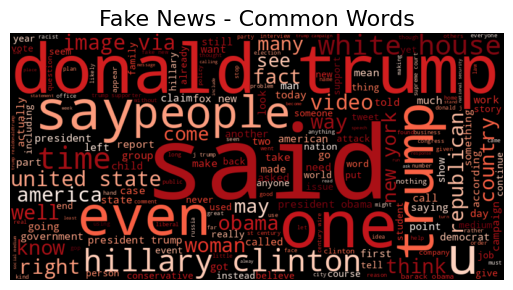

In [ ]:
plt.figure(figsize=(14, 6))

# Fake News WordCloud
plt.subplot(1, 2, 1)
wc_fake = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(fake_text)
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News - Common Words", fontsize=16)
plt.show()

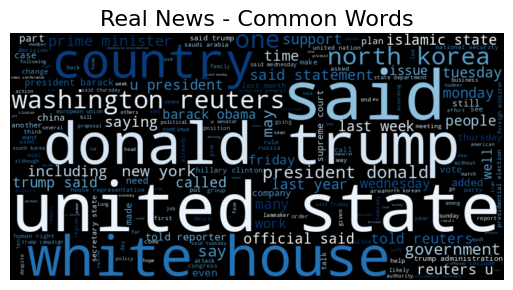

In [ ]:
plt.figure(figsize=(14, 6))

# Real News WordCloud
plt.subplot(1, 2, 2)
wc_real = WordCloud(width=800, height=400, background_color="black", colormap="Blues").generate(real_text)
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("Real News - Common Words", fontsize=16)

plt.show()